## Random Forest - sensor stability - 2bins - 37/63

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")

In [3]:
df = pd.read_csv(f"../StabilityGasSensors_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sensor                   19 non-null     object 
 1   dopant_type              19 non-null     object 
 2   dopant_dose              19 non-null     float64
 3   calcination_temperature  19 non-null     object 
 4   BET_fresh                19 non-null     float64
 5   particle_size_fresh      19 non-null     float64
 6   BET_aged                 19 non-null     float64
 7   particle_size_aged       19 non-null     float64
 8   fresh_point              19 non-null     float64
 9   5th_day                  19 non-null     float64
 10  8th_day                  16 non-null     float64
 11  12th_day                 18 non-null     float64
 12  15th_day                 19 non-null     float64
 13  diff_0_5day              19 non-null     float64
 14  diff_0_5day_binned       19 

In [4]:
df["dopant_type"].unique()

array(['no dopant', 'Mo', 'Ce', 'Sm', 'Si'], dtype=object)

In [5]:
df["calcination_temperature"].unique()

array(['no calcination', '700', '850'], dtype=object)

In [6]:
target = "diff_5_15day_2bins"
representation = ["dopant_type", "dopant_dose", "calcination_temperature"]
random_state=42
train_size=10

In [7]:
encoder_dopant = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder_dopant.fit_transform(df[["dopant_type"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [8]:
df.columns

Index(['sensor', 'dopant_type', 'dopant_dose', 'calcination_temperature',
       'BET_fresh', 'particle_size_fresh', 'BET_aged', 'particle_size_aged',
       'fresh_point', '5th_day', '8th_day', '12th_day', '15th_day',
       'diff_0_5day', 'diff_0_5day_binned', 'diff_5_15day',
       'diff_5_15day_2bins', 'diff_5_15day_3bins', 'diff_5_15day_5050',
       'synthesis', 'synthesis_BET', 'dopant_type_Ce', 'dopant_type_Mo',
       'dopant_type_Si', 'dopant_type_Sm', 'dopant_type_no dopant'],
      dtype='object')

In [9]:
encoder_temp = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder_temp.fit_transform(df[["calcination_temperature"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [10]:
df.columns

Index(['sensor', 'dopant_type', 'dopant_dose', 'calcination_temperature',
       'BET_fresh', 'particle_size_fresh', 'BET_aged', 'particle_size_aged',
       'fresh_point', '5th_day', '8th_day', '12th_day', '15th_day',
       'diff_0_5day', 'diff_0_5day_binned', 'diff_5_15day',
       'diff_5_15day_2bins', 'diff_5_15day_3bins', 'diff_5_15day_5050',
       'synthesis', 'synthesis_BET', 'dopant_type_Ce', 'dopant_type_Mo',
       'dopant_type_Si', 'dopant_type_Sm', 'dopant_type_no dopant',
       'calcination_temperature_700', 'calcination_temperature_850',
       'calcination_temperature_no calcination'],
      dtype='object')

In [11]:
df.columns[21:30].to_list()

['dopant_type_Ce',
 'dopant_type_Mo',
 'dopant_type_Si',
 'dopant_type_Sm',
 'dopant_type_no dopant',
 'calcination_temperature_700',
 'calcination_temperature_850',
 'calcination_temperature_no calcination']

In [12]:
representation = ["dopant_dose"]
representation.extend(df.columns[21:30].to_list())

In [13]:
representation

['dopant_dose',
 'dopant_type_Ce',
 'dopant_type_Mo',
 'dopant_type_Si',
 'dopant_type_Sm',
 'dopant_type_no dopant',
 'calcination_temperature_700',
 'calcination_temperature_850',
 'calcination_temperature_no calcination']

In [14]:
def prepare_dataset_classification(
    df,
    target = "diff_5_15day_2bins",
    representation = representation,
    random_state=42,
    train_size=10
):
    df_train, df_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )

    print(len(df_train), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return X_train, y_train, X_test, y_test

In [15]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, random_state=42):
    clf = RandomForestClassifier(
        n_estimators=100, 
        random_state=random_state,
        verbose=True
    )
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [16]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 5

In [17]:
train_size = 5
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [18]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
5 14
random_state = 42
Accuracy: 0.42857142857142855
F1 macro: 0.37777777777777777
F1 micro: 0.42857142857142855
F1 weighted: 0.42857142857142855
Kappa: -0.24444444444444446
-------------Iteration 2/10
5 14
random_state = 43
Accuracy: 0.5
F1 macro: 0.4269005847953216
F1 micro: 0.5
F1 weighted: 0.4853801169590643
Kappa: -0.13953488372093026
-------------Iteration 3/10
5 14
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.5714285714285714
F1 macro: 0.5625
F1 micro: 0.5714285714285714
F1 weighted: 0.5803571428571429
Kappa: 0.1428571428571429
-------------Iteration 4/10
5 14
random_state = 45
Accuracy: 0.5714285714285714
F1 macro: 0.5333333333333333
F1 micro: 0.5714285714285714
F1 weighted: 0.5714285714285714
Kappa: 0.06666666666666665
-------------Iteration 5/10
5 14
random_state = 46
Accuracy: 0.5
F1 macro: 0.47593582887700536
F1 micro: 0.5
F1 weighted: 0.5080213903743316
Kappa: -0.042553191489361764
-------------Iteration 6/10
5 14
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7857142857142857
F1 macro: 0.7142857142857142
F1 micro: 0.7857142857142857
F1 weighted: 0.7551020408163264
Kappa: 0.46153846153846156
-------------Iteration 7/10
5 14
random_state = 48
Accuracy: 0.7857142857142857
F1 macro: 0.7142857142857142
F1 micro: 0.7857142857142857
F1 weighted: 0.7551020408163264
Kappa: 0.46153846153846156
-------------Iteration 8/10
5 14
random_state = 49
Accuracy: 0.5714285714285714
F1 macro: 0.5625
F1 micro: 0.5714285714285714
F1 weighted: 0.5803571428571429
Kappa: 0.1428571428571429
-------------Iteration 9/10
5 14
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.6428571428571429
F1 macro: 0.625668449197861
F1 micro: 0.6428571428571429
F1 weighted: 0.6485867074102368
Kappa: 0.25531914893617025
-------------Iteration 10/10
5 14
random_state = 51
Accuracy: 0.5
F1 macro: 0.47593582887700536
F1 micro: 0.5
F1 weighted: 0.5080213903743316
Kappa: -0.042553191489361764


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [19]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 5
mean accuracy: 0.5857142857142856 +/- 0.11428571428571428
mean F1 macro: 0.5469123231429733 +/- 0.10769642940875722
mean F1 micro: 0.5857142857142856 +/- 0.11428571428571428
mean F1 weighted: 0.5820927972464902 +/- 0.10406771224302766
mean Kappa: 0.10616913132499475 +/- 0.22507996705409264


In [20]:
compiled_res_5 = pd.DataFrame(metrics_dict())
compiled_res_5.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]","[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]",0.428571,0.377778,0.428571,0.428571,-0.244444
1,5,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]",0.500000,0.426901,0.500000,0.485380,-0.139535
2,5,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]","[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]",0.571429,0.562500,0.571429,0.580357,0.142857


### training size = 8

In [21]:
train_size = 8
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [22]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
8 11
random_state = 42
Accuracy: 0.8181818181818182
F1 macro: 0.7708333333333333
F1 micro: 0.8181818181818182
F1 weighted: 0.7992424242424242
Kappa: 0.56
-------------Iteration 2/10
8 11
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.6363636363636364
F1 macro: 0.5416666666666666
F1 micro: 0.6363636363636364
F1 weighted: 0.5984848484848485
Kappa: 0.1200000000000001
-------------Iteration 3/10
8 11
random_state = 44
Accuracy: 0.5454545454545454
F1 macro: 0.47619047619047616
F1 micro: 0.5454545454545454
F1 weighted: 0.528138528138528
Kappa: -0.037735849056603765
-------------Iteration 4/10
8 11
random_state = 45
Accuracy: 0.7272727272727273
F1 macro: 0.6857142857142857
F1 micro: 0.7272727272727273
F1 weighted: 0.7168831168831169
Kappa: 0.37735849056603776
-------------Iteration 5/10
8 11
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7272727272727273
F1 macro: 0.6857142857142857
F1 micro: 0.7272727272727273
F1 weighted: 0.7168831168831169
Kappa: 0.37735849056603776
-------------Iteration 6/10
8 11
random_state = 47
Accuracy: 0.7272727272727273
F1 macro: 0.611764705882353
F1 micro: 0.7272727272727273
F1 weighted: 0.6695187165775401
Kappa: 0.2978723404255319
-------------Iteration 7/10
8 11
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7272727272727273
F1 macro: 0.6857142857142857
F1 micro: 0.7272727272727273
F1 weighted: 0.7168831168831169
Kappa: 0.37735849056603776
-------------Iteration 8/10
8 11
random_state = 49
Accuracy: 0.45454545454545453
F1 macro: 0.45
F1 micro: 0.45454545454545453
F1 weighted: 0.43636363636363645
Kappa: 0.02941176470588236
-------------Iteration 9/10
8 11
random_state = 50
Accuracy: 0.7272727272727273
F1 macro: 0.6857142857142857
F1 micro: 0.7272727272727273
F1 weighted: 0.7168831168831169
Kappa: 0.37735849056603776
-------------Iteration 10/10
8 11
random_state = 51
Accuracy: 0.6363636363636364
F1 macro: 0.6071428571428572
F1 micro: 0.6363636363636364
F1 weighted: 0.6363636363636364
Kappa: 0.2142857142857143


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [24]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 8
mean accuracy: 0.6727272727272728 +/- 0.10123207932418224
mean F1 macro: 0.6200455182072829 +/- 0.09796660632797986
mean F1 micro: 0.6727272727272728 +/- 0.10123207932418224
mean F1 weighted: 0.6535644257703082 +/- 0.10185828926343572
mean Kappa: 0.26932679326246756 +/- 0.1758305578286476


In [25]:
compiled_res_8 = pd.DataFrame(metrics_dict())
compiled_res_8.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,8,"[1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1]","[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]",0.818182,0.770833,0.818182,0.799242,0.560000
1,8,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]",0.636364,0.541667,0.636364,0.598485,0.120000
2,8,"[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1]",0.545455,0.476190,0.545455,0.528139,-0.037736


### training size = 10

In [26]:
train_size = 10
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [27]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
10 9
random_state = 42
Accuracy: 0.8888888888888888
F1 macro: 0.8615384615384616
F1 micro: 0.8888888888888888
F1 weighted: 0.882051282051282
Kappa: 0.7272727272727273
-------------Iteration 2/10
10 9
random_state = 43
Accuracy: 0.5555555555555556
F1 macro: 0.35714285714285715
F1 micro: 0.5555555555555556
F1 weighted: 0.47619047619047616
Kappa: -0.20000000000000018
-------------Iteration 3/10
10 9
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.6666666666666666
F1 macro: 0.5846153846153846
F1 micro: 0.6666666666666666
F1 weighted: 0.6461538461538462
Kappa: 0.18181818181818188
-------------Iteration 4/10
10 9
random_state = 45
Accuracy: 0.7777777777777778
F1 macro: 0.75
F1 micro: 0.7777777777777778
F1 weighted: 0.7777777777777778
Kappa: 0.5
-------------Iteration 5/10
10 9
random_state = 46
Accuracy: 0.6666666666666666
F1 macro: 0.5846153846153846
F1 micro: 0.6666666666666666
F1 weighted: 0.6461538461538462
Kappa: 0.18181818181818188
-------------Iteration 6/10
10 9
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.5555555555555556
F1 macro: 0.5
F1 micro: 0.5555555555555556
F1 weighted: 0.5555555555555556
Kappa: 0.0
-------------Iteration 7/10
10 9
random_state = 48
Accuracy: 0.6666666666666666
F1 macro: 0.5846153846153846
F1 micro: 0.6666666666666666
F1 weighted: 0.6461538461538462
Kappa: 0.18181818181818188
-------------Iteration 8/10
10 9
random_state = 49
Accuracy: 0.6666666666666666
F1 macro: 0.5846153846153846
F1 micro: 0.6666666666666666
F1 weighted: 0.6461538461538462
Kappa: 0.18181818181818188
-------------Iteration 9/10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


10 9
random_state = 50
Accuracy: 0.6666666666666666
F1 macro: 0.5846153846153846
F1 micro: 0.6666666666666666
F1 weighted: 0.6461538461538462
Kappa: 0.18181818181818188
-------------Iteration 10/10
10 9
random_state = 51
Accuracy: 0.6666666666666666
F1 macro: 0.6493506493506493
F1 micro: 0.6666666666666666
F1 weighted: 0.6753246753246753
Kappa: 0.3076923076923076


In [29]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 10
mean accuracy: 0.6777777777777778 +/- 0.09229582069908972
mean F1 macro: 0.6041108891108891 +/- 0.12780136272818582
mean F1 micro: 0.6777777777777778 +/- 0.09229582069908972
mean F1 weighted: 0.6597668997668997 +/- 0.10443459293527167
mean Kappa: 0.2244055944055944 +/- 0.23985635789797077


In [30]:
compiled_res_10 = pd.DataFrame(metrics_dict())
compiled_res_10.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,10,"[0, 1, 1, 0, 1, 0, 1, 1, 1]","[1, 1, 1, 0, 1, 0, 1, 1, 1]",0.888889,0.861538,0.888889,0.882051,0.727273
1,10,"[1, 1, 0, 1, 1, 0, 0, 1, 1]","[1, 0, 1, 1, 1, 1, 1, 1, 1]",0.555556,0.357143,0.555556,0.476190,-0.200000
2,10,"[1, 1, 1, 0, 1, 0, 0, 1, 1]","[1, 1, 1, 1, 1, 0, 1, 0, 1]",0.666667,0.584615,0.666667,0.646154,0.181818


### training size = 12

In [31]:
train_size = 12
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [32]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
12 7
random_state = 42
Accuracy: 0.8571428571428571
F1 macro: 0.8444444444444444
F1 micro: 0.8571428571428571
F1 weighted: 0.8507936507936508
Kappa: 0.6956521739130435
-------------Iteration 2/10
12 7
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 3/10
12 7
random_state = 44
Accuracy: 0.7142857142857143
F1 macro: 0.65
F1 micro: 0.7142857142857143
F1 weighted: 0.6714285714285715
Kappa: 0.36363636363636376
-------------Iteration 4/10
12 7
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8571428571428571
F1 macro: 0.8444444444444444
F1 micro: 0.8571428571428571
F1 weighted: 0.8507936507936508
Kappa: 0.6956521739130435
-------------Iteration 5/10
12 7
random_state = 46
Accuracy: 0.5714285714285714
F1 macro: 0.5333333333333333
F1 micro: 0.5714285714285714
F1 weighted: 0.5523809523809524
Kappa: 0.08695652173913038
-------------Iteration 6/10
12 7
random_state = 47
Accuracy: 0.5714285714285714
F1 macro: 0.5333333333333333
F1 micro: 0.5714285714285714
F1 weighted: 0.5523809523809524
Kappa: 0.08695652173913038
-------------Iteration 7/10
12 7
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.5714285714285714
F1 macro: 0.5333333333333333
F1 micro: 0.5714285714285714
F1 weighted: 0.5523809523809524
Kappa: 0.08695652173913038
-------------Iteration 8/10
12 7
random_state = 49
Accuracy: 0.7142857142857143
F1 macro: 0.65
F1 micro: 0.7142857142857143
F1 weighted: 0.6714285714285715
Kappa: 0.36363636363636376
-------------Iteration 9/10
12 7
random_state = 50
Accuracy: 0.5714285714285714
F1 macro: 0.5333333333333333
F1 micro: 0.5714285714285714
F1 weighted: 0.5523809523809524
Kappa: 0.08695652173913038
-------------Iteration 10/10
12 7
random_state = 51


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.7142857142857143
F1 macro: 0.7083333333333333
F1 micro: 0.7142857142857143
F1 weighted: 0.7142857142857143
Kappa: 0.41666666666666663


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [33]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 12
mean accuracy: 0.6714285714285715 +/- 0.11157499537009506
mean F1 macro: 0.6194191919191919 +/- 0.14356767748190827
mean F1 micro: 0.6714285714285715 +/- 0.11157499537009506
mean F1 weighted: 0.6383838383838383 +/- 0.1331940046505172
mean Kappa: 0.28830698287220025 +/- 0.24596227315007332


In [34]:
compiled_res_12 = pd.DataFrame(metrics_dict())
compiled_res_12.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,12,"[0, 1, 0, 1, 0, 1, 1]","[1, 1, 0, 1, 0, 1, 1]",0.857143,0.844444,0.857143,0.850794,0.695652
1,12,"[1, 1, 0, 1, 1, 0, 0]","[1, 1, 1, 1, 1, 1, 1]",0.571429,0.363636,0.571429,0.415584,0.000000
2,12,"[1, 1, 1, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 0, 1]",0.714286,0.650000,0.714286,0.671429,0.363636


### training size = 13

In [35]:
train_size = 13
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [36]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
13 6
random_state = 42
Accuracy: 0.8333333333333334
F1 macro: 0.7777777777777777
F1 micro: 0.8333333333333334
F1 weighted: 0.8148148148148148
Kappa: 0.5714285714285714
-------------Iteration 2/10
13 6
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8333333333333334
F1 macro: 0.7777777777777777
F1 micro: 0.8333333333333334
F1 weighted: 0.8148148148148148
Kappa: 0.5714285714285714
-------------Iteration 3/10
13 6
random_state = 44
Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 4/10
13 6
random_state = 45
Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 5/10
13 6
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 6/10
13 6
random_state = 47
Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 7/10
13 6
random_state = 48


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.6666666666666666
F1 macro: 0.4
F1 micro: 0.6666666666666666
F1 weighted: 0.5333333333333333
Kappa: 0.0
-------------Iteration 8/10
13 6
random_state = 49
Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 9/10
13 6
random_state = 50
Accuracy: 0.6666666666666666
F1 macro: 0.625
F1 micro: 0.6666666666666666
F1 weighted: 0.6666666666666666
Kappa: 0.25
-------------Iteration 10/10
13 6
random_state = 51
Accuracy: 0.8333333333333334
F1 macro: 0.8285714285714285
F1 micro: 0.8333333333333334
F1 weighted: 0.8380952380952381
Kappa: 0.6666666666666667


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [37]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 13
mean accuracy: 0.7166666666666666 +/- 0.07637626158259737
mean F1 macro: 0.6534126984126984 +/- 0.11431343358727998
mean F1 micro: 0.7166666666666666 +/- 0.07637626158259737
mean F1 weighted: 0.7001058201058201 +/- 0.08937533812635197
mean Kappa: 0.33095238095238094 +/- 0.19421917628126775


In [38]:
compiled_res_13 = pd.DataFrame(metrics_dict())
compiled_res_13.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,13,"[0, 1, 1, 0, 1, 1]","[0, 1, 1, 1, 1, 1]",0.833333,0.777778,0.833333,0.814815,0.571429
1,13,"[1, 0, 1, 1, 1, 0]","[1, 0, 1, 1, 1, 1]",0.833333,0.777778,0.833333,0.814815,0.571429
2,13,"[1, 1, 1, 0, 1, 0]","[0, 1, 1, 1, 1, 0]",0.666667,0.625000,0.666667,0.666667,0.250000


### training size = 14

In [39]:
train_size = 14
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [40]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
14 5
random_state = 42
Accuracy: 0.6
F1 macro: 0.5833333333333333
F1 micro: 0.6
F1 weighted: 0.6
Kappa: 0.16666666666666663
-------------Iteration 2/10
14 5
random_state = 43
Accuracy: 0.8
F1 macro: 0.7619047619047619
F1 micro: 0.8
F1 weighted: 0.7809523809523808
Kappa: 0.5454545454545454
-------------Iteration 3/10
14 5
random_state = 44


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


Accuracy: 0.8
F1 macro: 0.7619047619047619
F1 micro: 0.8
F1 weighted: 0.7809523809523808
Kappa: 0.5454545454545454
-------------Iteration 4/10
14 5
random_state = 45
Accuracy: 0.8
F1 macro: 0.7619047619047619
F1 micro: 0.8
F1 weighted: 0.7809523809523808
Kappa: 0.5454545454545454
-------------Iteration 5/10
14 5
random_state = 46


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.7619047619047619
F1 micro: 0.8
F1 weighted: 0.7809523809523808
Kappa: 0.5454545454545454
-------------Iteration 6/10
14 5
random_state = 47
Accuracy: 0.6
F1 macro: 0.5833333333333333
F1 micro: 0.6
F1 weighted: 0.6
Kappa: 0.16666666666666663
-------------Iteration 7/10
14 5
random_state = 48
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 8/10
14 5
random_state = 49


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.8
F1 macro: 0.7619047619047619
F1 micro: 0.8
F1 weighted: 0.7809523809523808
Kappa: 0.5454545454545454
-------------Iteration 9/10
14 5
random_state = 50
Accuracy: 0.6
F1 macro: 0.5833333333333333
F1 micro: 0.6
F1 weighted: 0.6
Kappa: 0.16666666666666663
-------------Iteration 10/10
14 5
random_state = 51
Accuracy: 1.0
F1 macro: 1.0
F1 micro: 1.0
F1 weighted: 1.0
Kappa: 1.0


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [41]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 14
mean accuracy: 0.74 +/- 0.128062484748657
mean F1 macro: 0.6934523809523808 +/- 0.15974686786094813
mean F1 micro: 0.74 +/- 0.128062484748657
mean F1 weighted: 0.7154761904761904 +/- 0.14590110184393526
mean Kappa: 0.4227272727272727 +/- 0.2799916370258364


In [42]:
compiled_res_14 = pd.DataFrame(metrics_dict())
compiled_res_14.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,14,"[0, 0, 1, 1, 1]","[1, 0, 0, 1, 1]",0.6,0.583333,0.6,0.600000,0.166667
1,14,"[0, 1, 1, 1, 0]","[0, 1, 1, 1, 1]",0.8,0.761905,0.8,0.780952,0.545455
2,14,"[1, 0, 1, 1, 0]","[1, 1, 1, 1, 0]",0.8,0.761905,0.8,0.780952,0.545455


### training size = 15

In [43]:
train_size = 15
iterations = 10
target = "diff_5_15day_2bins"
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [44]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        target,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
15 4
random_state = 42
Accuracy: 0.75
F1 macro: 0.7333333333333334
F1 micro: 0.75
F1 weighted: 0.7666666666666667
Kappa: 0.5
-------------Iteration 2/10
15 4
random_state = 43


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 1.0
F1 macro: 1.0
F1 micro: 1.0
F1 weighted: 1.0
Kappa: 1.0
-------------Iteration 3/10
15 4
random_state = 44
Accuracy: 1.0
F1 macro: 1.0
F1 micro: 1.0
F1 weighted: 1.0
Kappa: 1.0
-------------Iteration 4/10
15 4
random_state = 45


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.75
F1 macro: 0.42857142857142855
F1 micro: 0.75
F1 weighted: 0.6428571428571428
Kappa: 0.0
-------------Iteration 5/10
15 4
random_state = 46
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.5
Kappa: -0.33333333333333326
-------------Iteration 6/10
15 4
random_state = 47


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.75
F1 macro: 0.7333333333333334
F1 micro: 0.75
F1 weighted: 0.7666666666666667
Kappa: 0.5
-------------Iteration 7/10
15 4
random_state = 48
Accuracy: 0.25
F1 macro: 0.2
F1 micro: 0.25
F1 weighted: 0.30000000000000004
Kappa: -0.5
-------------Iteration 8/10
15 4
random_state = 49
Accuracy: 1.0
F1 macro: 1.0
F1 micro: 1.0
F1 weighted: 1.0
Kappa: 1.0
-------------Iteration 9/10
15 4
random_state = 50


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.5
Kappa: -0.33333333333333326
-------------Iteration 10/10
15 4
random_state = 51
Accuracy: 1.0
F1 macro: 1.0
F1 micro: 1.0
F1 weighted: 1.0
Kappa: 1.0


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [45]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 15
mean accuracy: 0.75 +/- 0.25
mean F1 macro: 0.6761904761904762 +/- 0.30807720562523017
mean F1 micro: 0.75 +/- 0.25
mean F1 weighted: 0.7476190476190476 +/- 0.24279177458264242
mean Kappa: 0.3833333333333334 +/- 0.5918426968188234


In [46]:
compiled_res_15 = pd.DataFrame(metrics_dict())
compiled_res_15.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[1, 0, 1, 1]","[1, 0, 1, 0]",0.75,0.733333,0.75,0.766667,0.5
1,15,"[1, 1, 1, 0]","[1, 1, 1, 0]",1.00,1.000000,1.00,1.000000,1.0
2,15,"[1, 0, 1, 1]","[1, 0, 1, 1]",1.00,1.000000,1.00,1.000000,1.0


In [47]:
compiled_res = pd.concat([
    compiled_res_5, 
    compiled_res_8,
    compiled_res_10,
    compiled_res_12,
    compiled_res_13,
    compiled_res_14,
    compiled_res_15
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

70


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]","[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]",0.428571,0.377778,0.428571,0.428571,-0.244444
1,5,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]",0.500000,0.426901,0.500000,0.485380,-0.139535
2,5,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]","[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]",0.571429,0.562500,0.571429,0.580357,0.142857
3,5,"[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]","[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1]",0.571429,0.533333,0.571429,0.571429,0.066667
4,5,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]",0.500000,0.475936,0.500000,0.508021,-0.042553


In [48]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [55]:
compiled_res.to_csv("RF_results_sensorStability_2bins_3763.csv", sep=",", index=False)

In [56]:
df = pd.read_csv("RF_results_sensorStability_2bins_3763.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   70 non-null     int64  
 1   y_true       70 non-null     object 
 2   y_pred       70 non-null     object 
 3   accuracy     70 non-null     float64
 4   f1_macro     70 non-null     float64
 5   f1_micro     70 non-null     float64
 6   f1_weighted  70 non-null     float64
 7   kappa        70 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.5+ KB


In [57]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0]","[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]",0.428571,0.377778,0.428571,0.428571,-0.244444
1,5,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]",0.500000,0.426901,0.500000,0.485380,-0.139535
2,5,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1]","[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]",0.571429,0.562500,0.571429,0.580357,0.142857


In [58]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5           0.585714  0.038095  0.546912  0.035899  0.585714  0.038095   
8           0.672727  0.033744  0.620046  0.032656  0.672727  0.033744   
10          0.677778  0.030765  0.604111  0.042600  0.677778  0.030765   
12          0.671429  0.037192  0.619419  0.047856  0.671429  0.037192   
13          0.716667  0.025459  0.653413  0.038104  0.716667  0.025459   
14          0.740000  0.042687  0.693452  0.053249  0.740000  0.042687   
15          0.750000  0.083333  0.676190  0.102692  0.750000  0.083333   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
5             0.582093  0.034689  0.106169  0.075027  
8             0.653564  0.033953  0.269327  0.058610  
10            0.659767  0.034812  0.224406  0.079952  
12            0.638384  0.044398  0.288307  0.081987  
13            0.700106  0.029792  0.330952  0.064740  
14            0.715476  0.048634  0.422727  0.093331  
15            0.747619  0.080931  0.383333  0.197281

In [59]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.6 0.4]
 [0.2 0.8]]
accuracy: 0.75


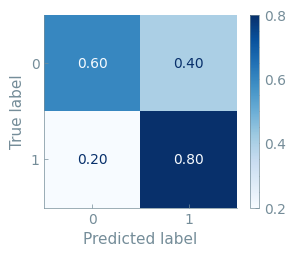

In [60]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_sensorStability_confusionMatrix_37_63_120ep_size15_RF.pdf', bbox_inches='tight')